# SEA-AD: Full Dataset GNN Analysis

**Goal:** Analyze the GNN model trained on the **Full SEA-AD Dataset** (~1.2M cells).

**Files:**
- Graph: `data/processed/graphs/cell_graph.pt`
- Model: `outputs/cell_model.ckpt`

**Hardware:** GPU Acceleration enabled for inference.

In [2]:
import os
# Fix OpenMP conflict on Windows (OMP Error #15)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn.functional as F
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sys

# Add src to path
sys.path.append(os.path.abspath('../src'))
from models.gnn_models import CellGNN

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)

# Force GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1. Load Full Graph Data
This loads the processed PyTorch Geometric graph containing ~1.2M cells.

In [3]:
data_path = '../data/processed/graphs/cell_graph.pt'

if os.path.exists(data_path):
    print(f"Loading graph from {data_path}...")
    # Loading with weights_only=False for PyG Data objects
    try:
        data = torch.load(data_path, weights_only=False)
    except TypeError:
        data = torch.load(data_path)
        
    print(f"Graph Statistics:")
    print(f"  - Nodes (Cells): {data.num_nodes}")
    print(f"  - Features (PCs): {data.num_features}")
    print(f"  - Edges: {data.num_edges}")
    print(f"  - Classes: {len(torch.unique(data.y)) if data.y is not None else 'Unknown'}")
else:
    print(f"Error: {data_path} not found. Run build_graphs.py first.")

Loading graph from ../data/processed/graphs/cell_graph.pt...
Graph Statistics:
  - Nodes (Cells): 1040014
  - Features (PCs): 50
  - Edges: 23655088
  - Classes: 2


### 2. Load Trained Model
Loads the `CellGNN` checkpoint from the full training run.

In [4]:
ckpt_path = '../outputs/cell_model.ckpt'

if os.path.exists(ckpt_path) and 'data' in locals():
    print(f"Loading model from {ckpt_path}...")
    num_classes = len(torch.unique(data.y)) if data.y is not None else 2
    
    # Initialize model (Must match training config: heads=1, hidden=64)
    model = CellGNN(in_channels=data.num_features, hidden_channels=64, out_channels=num_classes, heads=1)
    
    try:
        checkpoint = torch.load(ckpt_path, map_location=device)
        # Handle Lightning checkpoint format
        if 'state_dict' in checkpoint:
            state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
        else:
            state_dict = checkpoint
            
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        print("Model loaded and moved to GPU.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
else:
    print("Checkpoint or Data missing.")

Loading model from ../outputs/cell_model.ckpt...
Model loaded and moved to GPU.


### 3. Run Inference (GPU)
We run the model on the full graph to get predictions.

In [8]:
if 'model' in locals() and 'data' in locals():
    print("Running inference on GPU...")
    data = data.to(device)
    
    with torch.no_grad():
        # Get Model Output (Logits)
        out = model(data.x, data.edge_index)
        preds = out.argmax(dim=1).cpu().numpy()
        probs = out.softmax(dim=1).cpu().numpy()
        
        # Move ground truth to CPU for metrics
        y_true = data.y.cpu().numpy() if data.y is not None else None

    print("Inference complete.")

Running inference on GPU...
Inference complete.


### 4. Metrics & Confusion Matrix
Evaluate classification performance on the full dataset.

Classification Report:
              precision    recall  f1-score   support

 No Dementia       0.55      0.75      0.64    575468
    Dementia       0.44      0.24      0.31    464546

    accuracy                           0.53   1040014
   macro avg       0.50      0.50      0.48   1040014
weighted avg       0.50      0.53      0.49   1040014



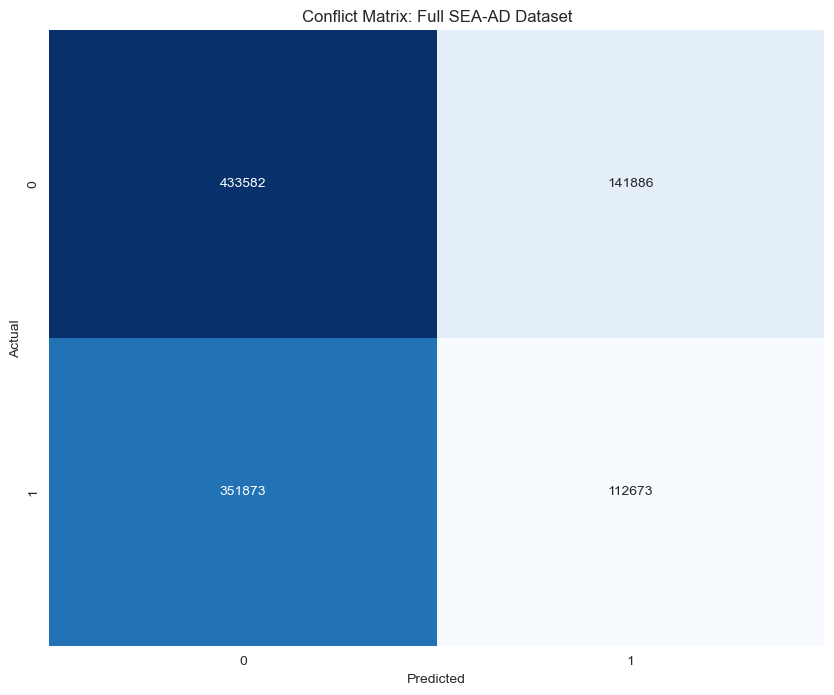

In [6]:
if y_true is not None:
    print("Classification Report:")
    print(classification_report(y_true, preds, target_names=['No Dementia', 'Dementia'] if num_classes==2 else None))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Conflict Matrix: Full SEA-AD Dataset')
    plt.show()
else:
    print("No ground truth labels available.")

### 5. Visualization (UMAP)
Visualize the graph structure and predictions.
**Note:** Plotting 1M points is slow and clutters the plot. We randomly subsample 100,000 cells for clear visualization.

Subsampling to 100000 cells for UMAP visualization...
Computing UMAP on Input Features (PCA)...


c:\Users\thoma\miniconda3\envs\brain-gnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Plotting...


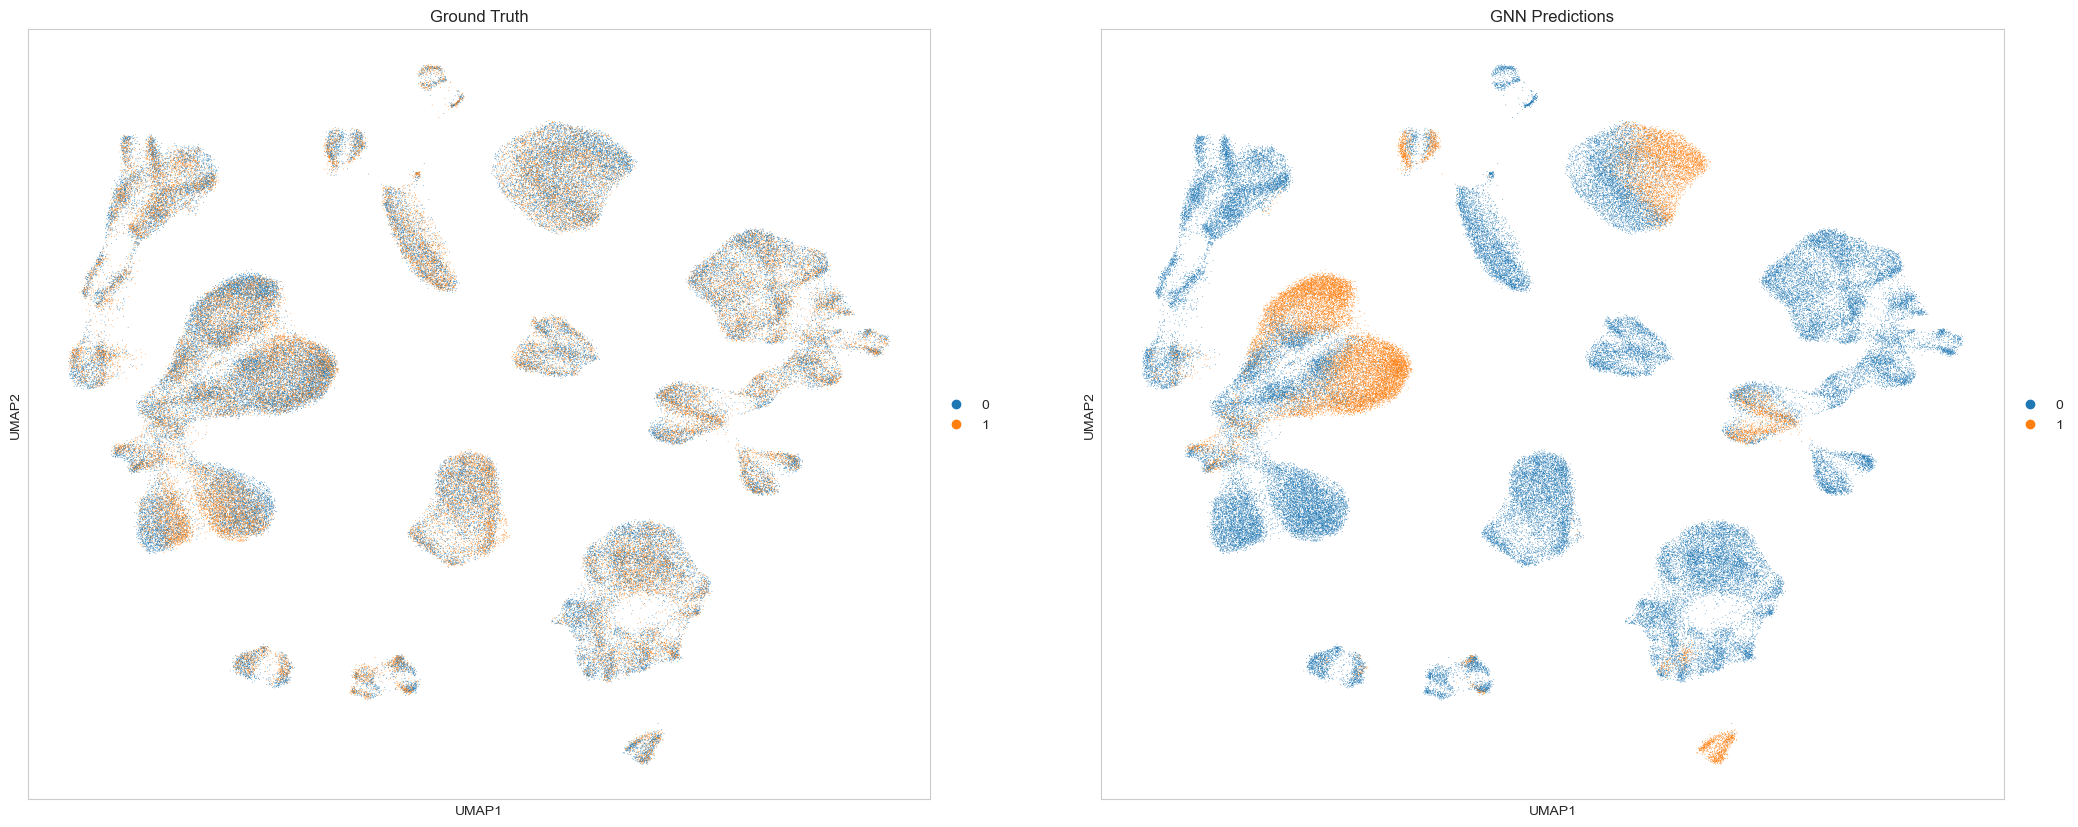

In [7]:
# Subsample for UMAP
n_subsample = 100000
if data.num_nodes > n_subsample:
    print(f"Subsampling to {n_subsample} cells for UMAP visualization...")
    indices = np.random.choice(data.num_nodes, n_subsample, replace=False)
    x_sub = data.x.cpu().numpy()[indices]
    y_sub = y_true[indices] if y_true is not None else None
    pred_sub = preds[indices]
else:
    x_sub = data.x.cpu().numpy()
    y_sub = y_true
    pred_sub = preds

print("Computing UMAP on Input Features (PCA)...")
# Use Scanpy for nice plotting
adata_vis = sc.AnnData(X=x_sub)
if y_sub is not None: 
    adata_vis.obs['Actual'] = pd.Categorical(y_sub)
adata_vis.obs['Predicted'] = pd.Categorical(pred_sub)

# Run UMAP
sc.pp.neighbors(adata_vis, use_rep='X')
sc.tl.umap(adata_vis)

# Plot
print("Plotting...")
sc.pl.umap(adata_vis, color=['Actual', 'Predicted'], title=['Ground Truth', 'GNN Predictions'], ncols=2)
plt.show()